# Laboratorio 5

## Integrantes

### Sergio Orellana - 221122

### Andre Marroquin - 22266

### Rodrigo Mansilla - 22611

# Link del repositorio

https://github.com/mar22266/LABORATORIOS-IA.git


# Task 1 - Graph-Search


## Task 1.1 - Discretización de la imagen


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from collections import deque

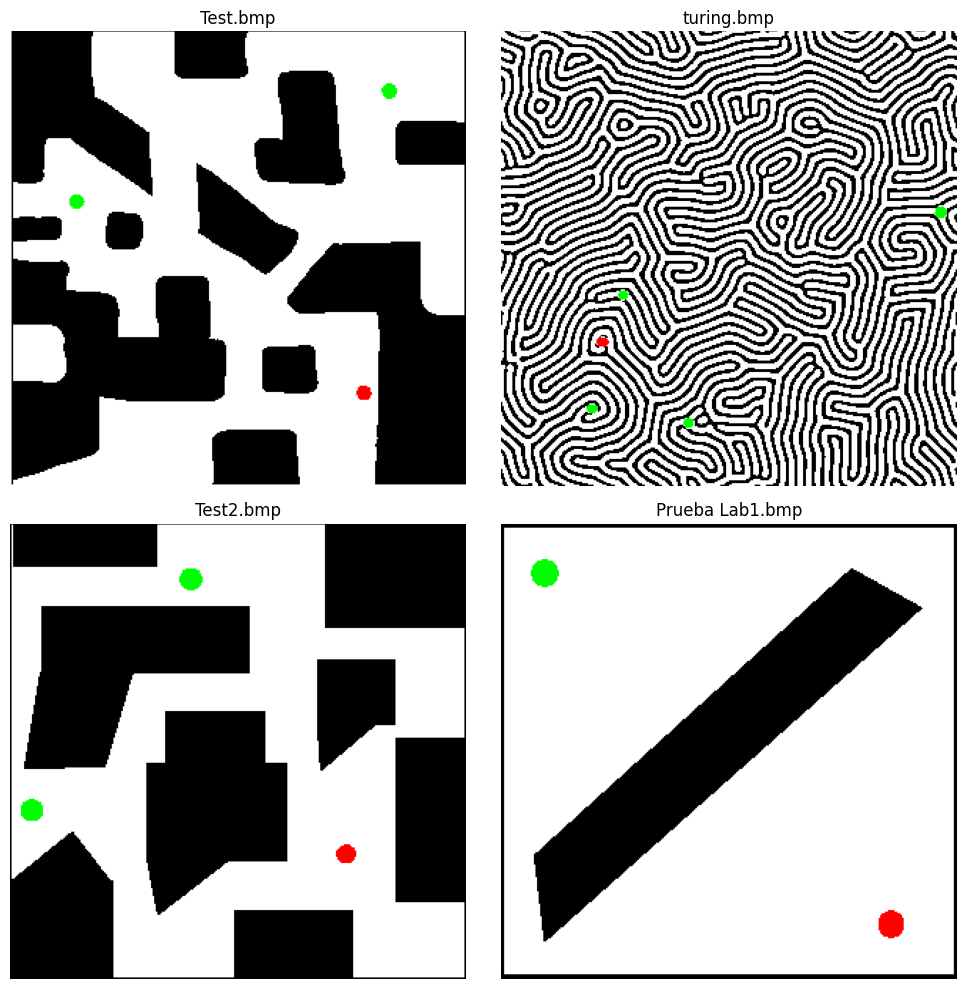

In [3]:
def load_maze(image_path, cell_size):
    img = Image.open(image_path).convert("RGB")
    width, height = img.size

    grid_size = width // cell_size  # Se asume imagen cuadrada
    maze = np.zeros((grid_size, grid_size), dtype=int)

    for i in range(grid_size):
        for j in range(grid_size):
            block = img.crop(
                (j * cell_size, i * cell_size, (j + 1) * cell_size, (i + 1) * cell_size)
            )
            avg_color = np.array(block).mean(axis=(0, 1))

            if np.all(avg_color < 50):  # Negro -> Pared
                maze[i, j] = 1
            elif np.all(avg_color > 200):  # Blanco -> Camino libre
                maze[i, j] = 0
            elif (
                avg_color[1] > 150 and avg_color[0] < 100 and avg_color[2] < 100
            ):  # Verde -> Meta
                maze[i, j] = 2
            elif (
                avg_color[0] > 150 and avg_color[1] < 100 and avg_color[2] < 100
            ):  # Rojo -> Inicio
                maze[i, j] = 3

    return maze


# Cargar el laberinto
image_files = ["Test.bmp", "turing.bmp", "Test2.bmp", "Prueba Lab1.bmp"]

# Tamaño de celda para discretización
cell_size = 2

# Crear la figura para mostrar las imágenes en formato cuadrado
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Crear un mapa de colores personalizado
colors = {
    0: (1, 1, 1),  # Blanco (camino libre)
    1: (0, 0, 0),  # Negro (pared)
    2: (0, 1, 0),  # Verde (meta)
    3: (1, 0, 0),  # Rojo (inicio)
}

# Iterar sobre las imágenes y renderizarlas
for idx, image_path in enumerate(image_files):
    try:
        # Cargar el laberinto desde la imagen
        maze = load_maze(image_path, cell_size=cell_size)

        # Convertir la matriz a una imagen coloreada
        colored_maze = np.zeros((maze.shape[0], maze.shape[1], 3))
        for key, color in colors.items():
            colored_maze[maze == key] = color

        # Seleccionar el subplot correspondiente
        ax = axes[idx // 2, idx % 2]
        ax.imshow(colored_maze)
        ax.set_title(image_path.split("/")[-1])  # Nombre del archivo
        ax.axis("off")  # Ocultar ejes
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

## Task 1.2 - Framework de Problemas


In [50]:
from abc import ABC, abstractmethod


class SearchProblem(ABC):
    """
    Clase abstracta para definir un problema de búsqueda.
    """

    @abstractmethod
    def initial_state(self):
        """Retorna el estado inicial"""
        pass

    @abstractmethod
    def goal_test(self, state):
        """Verifica si el estado dado es un estado meta"""
        pass

    @abstractmethod
    def actions(self, state):
        """Retorna la lista de acciones disponibles en un estado"""
        pass

    @abstractmethod
    def step_cost(self, state, action, next_state):
        """Retorna el costo de moverse de state a next_state con action"""
        pass

    @abstractmethod
    def result(self, state, action):
        """Retorna el nuevo estado tras aplicar una acción"""
        pass


class MazeProblem(SearchProblem):
    def __init__(self, maze):
        """
        Recibe una matriz discreta del laberinto.
        0 -> Camino libre
        1 -> Pared
        2 -> Meta
        3 -> Inicio
        """
        self.maze = maze
        self.height, self.width = maze.shape
        self.start = None
        self.goals = []

        # Buscar el inicio y las metas en la matriz
        for i in range(self.height):
            for j in range(self.width):
                if maze[i, j] == 3:
                    self.start = (i, j)
                elif maze[i, j] == 2:
                    self.goals.append((i, j))

    def initial_state(self):
        return self.start

    def goal_test(self, state):
        return state in self.goals

    def actions(self, state):
        """Retorna las acciones posibles: Arriba, Abajo, Izquierda, Derecha"""
        x, y = state
        possible_actions = []

        if x > 0 and self.maze[x - 1, y] != 1:
            possible_actions.append("UP")
        if x < self.height - 1 and self.maze[x + 1, y] != 1:
            possible_actions.append("DOWN")
        if y > 0 and self.maze[x, y - 1] != 1:
            possible_actions.append("LEFT")
        if y < self.width - 1 and self.maze[x, y + 1] != 1:
            possible_actions.append("RIGHT")

        return possible_actions

    def step_cost(self, state, action, next_state):
        return 1  # Cada movimiento tiene un costo de 1

    def result(self, state, action):
        """Devuelve el nuevo estado tras aplicar una acción"""
        x, y = state
        if action == "UP":
            return (x - 1, y)
        elif action == "DOWN":
            return (x + 1, y)
        elif action == "LEFT":
            return (x, y - 1)
        elif action == "RIGHT":
            return (x, y + 1)
        return state

## Task 1.3 - Graph-Search


In [47]:
def breadth_first_search(problem):
    frontier = deque([problem.initial_state()])
    explored = set()

    while frontier:
        state = frontier.popleft()
        if problem.goal_test(state):
            return state
        explored.add(state)
        for action in problem.actions(state):
            next_state = problem.result(state, action)
            if next_state not in explored and next_state not in frontier:
                frontier.append(next_state)
    return None


def depth_first_search(problem):
    frontier = [problem.initial_state()]
    explored = set()

    while frontier:
        state = frontier.pop()
        if problem.goal_test(state):
            return state
        explored.add(state)
        for action in problem.actions(state):
            next_state = problem.result(state, action)
            if next_state not in explored and next_state not in frontier:
                frontier.append(next_state)
    return None


def heuristic_manhattan(state, goal):
    return abs(state[0] - goal[0]) + abs(state[1] - goal[1])


def heuristic_euclidean(state, goal):
    return math.sqrt((state[0] - goal[0]) ** 2 + (state[1] - goal[1]) ** 2)


def a_star_search(problem, heuristic):
    goal = problem.goals[0]  # Asumimos una única meta para simplificar
    frontier = [(0, problem.initial_state())]
    explored = set()

    while frontier:
        _, state = heapq.heappop(frontier)
        if problem.goal_test(state):
            return state
        explored.add(state)
        for action in problem.actions(state):
            next_state = problem.result(state, action)
            cost = problem.step_cost(state, action, next_state) + heuristic(
                next_state, goal
            )
            if next_state not in explored:
                heapq.heappush(frontier, (cost, next_state))
    return None

### Justifique la elección de estas heurísticas

La heurística de Manhattan se utiliza cuando el movimiento está restringido a direcciones ortogonales (arriba, abajo, izquierda, derecha), ya que mide el número mínimo de pasos necesarios en una cuadrícula y es admisible y consistente, lo que la hace ideal para laberintos sin diagonales.

Por otro lado, la heurística Euclidiana es más adecuada cuando se permiten movimientos diagonales, ya que calcula la distancia real entre dos puntos en un espacio continuo, proporcionando una estimación más precisa del costo.

Sabiendo esto, ambas heurísticas cumplen con los requisitos para A\*, pero en un laberinto tradicional, Manhattan es la mejor opción porque refleja fielmente el costo del camino más corto dentro de una cuadrícula ortogonal.


## Task 1.4 - Construcción de Salida
